In [142]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [143]:
# LOAD ROBOT
robot = loadKinton()
robot.initDisplay(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [144]:
def uavPlacementModel(targetPos, targetQuat, integrationStep, frameName):
    # ACTUATION MODEL
    actModel = ActuationModelUAM(rmodel)

    # COST MODEL
    # Create a cost model per the running and terminal action model.
    runningCostModel = CostModelSum(rmodel, actModel.nu)
    terminalCostModel = CostModelSum(rmodel, actModel.nu)

    state = StatePinocchio(rmodel)
    SE3ref = pin.SE3()
    SE3ref.translation = targetPos.reshape(3,1)
    SE3ref.rotation = targetQuat.matrix()


    stateWeights   = np.array([1] * 3 + [500.] * 3 + [1] * (robot.model.nv - 6) + [10] * robot.model.nv)
    controlWeights = np.array([10] + [100]*3 + [0]*6)
    
    goalTrackingCost = CostModelFramePlacement(rmodel,
                                               frame=rmodel.getFrameId(frameName),
                                               ref=SE3ref,
                                               nu =actModel.nu)
    xRegCost = CostModelState(rmodel, 
                              state, 
                              ref=state.zero(), 
                              nu=actModel.nu,
                              activation=ActivationModelWeightedQuad(stateWeights))
    uRegCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelWeightedQuad(controlWeights))

    # Then let's add the running and terminal cost functions
    runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
    runningCostModel.addCost(name="regx", weight=1e-7, cost=xRegCost)
    runningCostModel.addCost(name="regu", weight=1e-7, cost=uRegCost)
    terminalCostModel.addCost(name="pos", weight=50, cost=goalTrackingCost)

    # DIFFERENTIAL ACTION MODEL
    dmodel = DifferentialActionModelUAM(rmodel, actModel, runningCostModel)
    model = IntegratedActionModelEuler(dmodel)
    # terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))
    model.timeStep =  integrationStep  
    return model   

In [145]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 1e-3

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 500


# DEFINE POSITION WAYPOINTS
target_pos = [np.array([0,0,1])]
target_pos += [np.array([0,1,1])]
quat = pin.Quaternion(1, 0, 0, 0)
quat.normalize()
target_quat = [quat]*2

# Plot goal frame
for i in range(0,len(target_pos)):
    robot.viewer.gui.addXYZaxis('world/wp%i' % i, [1., 0., 0., 1.], .03, 0.5)
    robot.viewer.gui.applyConfiguration('world/wp%i' % i, 
                                        target_pos[i].tolist() + [target_quat[i][0], target_quat[i][1], target_quat[i][2], target_quat[i][3]])
    
robot.viewer.gui.refresh()

In [147]:
models = []
for i in range(0,len(target_pos)):
    if (i==1):
        T *=2
    models += [uavPlacementModel(target_pos[i], target_quat[i], dt, 'base_link')]*T

q0 = rmodel.referenceConfigurations["initial_pose"]
x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])

problem = ShootingProblem(x0, models, models[-1])

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  3.97457e+01  2.08906e-04  2.41011e+02  1.00000e-09  1.00000e-09   0.5000     1
   1  1.10793e+01  4.53633e-05  5.97849e+01  1.00000e-09  1.00000e-09   1.0000     1
   2  1.01565e+01  2.42949e-06  3.76099e+00  1.00000e-09  1.00000e-09   1.0000     1
   3  9.76884e+00  8.32987e-07  2.52613e+00  1.00000e-09  1.00000e-09   1.0000     1
   4  9.13684e+00  1.18071e-06  2.19813e+00  1.00000e-09  1.00000e-09   0.5000     1
   5  8.96605e+00  1.38521e-07  3.67390e-01  1.00000e-09  1.00000e-09   1.0000     1
   6  8.92550e+00  7.83990e-08  9.75298e-02  1.00000e-09  1.00000e-09   1.0000     1
   7  8.90109e+00  9.22638e-09  6.90553e-02  1.00000e-09  1.00000e-09   1.0000     1
   8  8.88559e+00  4.17658e-08  5.66320e-02  1.00000e-09  1.00000e-09   1.0000     1
   9  8.87454e+00  1.27683e-08  5.52753e-02  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  8.86695e

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([-1.18103651e-10, -5.01116915e-06,  2.03945446e-04, -2.74759572e-03,
          2.03446692e-08, -1.52198273e-06,  9.99996225e-01, -3.09068502e-06,
         -8.80675197e-03,  1.15385083e-04, -5.23318479e-05, -1.44060068e-04,
         -1.91018052e-03, -1.14341557e-07, -5.57151688e-03,  2.03931164e-01,
         -5.49519834e+00,  4.06893895e-05, -3.04396929e-03, -3.09068502e-03,
         -8.80675197e+00,  1.15385083e-01, -5.23318479e-02, -1.44060068e-01,
         -1.91018052e+00]),
  array([ 6.10081147e-09, -7.76300467e-06,  6.07750077e-04, -5.15150974e-03,
         -3.86303100e-06, -2.66878052e-06,  9.99986731e-01, -5.10604467e-06,
         -1.65128170e-02,  2.23843168e-04, -1.11437143e-04, -2.92959825e-04,
         -3.58370737e-03,  7.78859475e-06, -5.94142815e-03,  4.03770685e-01,
         -4.80786669e+00, -7.76774468e-03, -2.31505576e-03, -2.01535965e-03,
     

In [148]:
displayTrajectory(robot, ddp.xs, dt)

In [149]:
# Control trajectory
thrust = []
Mr = [];
Mp = [];
My = [];

for u in ddp.us:
    thrust.append(u[0])
    Mr.append(u[1])
    Mp.append(u[2])
    My.append(u[3])

# State trajectory
Xx = [];
Xy = [];
Xz = [];
Vx = [];
Vy = [];
Vz = [];


for x in ddp.xs:
    Xx.append(x[0])
    Xy.append(x[1])
    Xz.append(x[2])
    Vx.append(x[13])
    Vy.append(x[14])
    Vz.append(x[15])

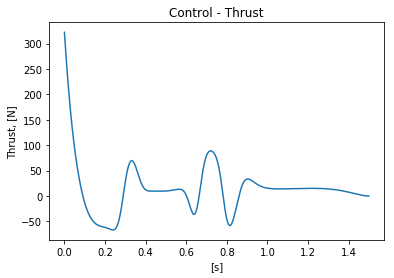

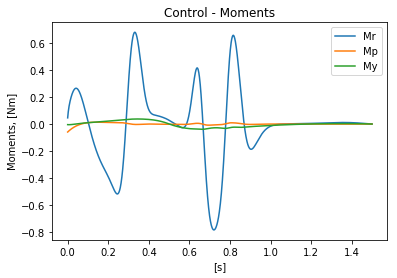

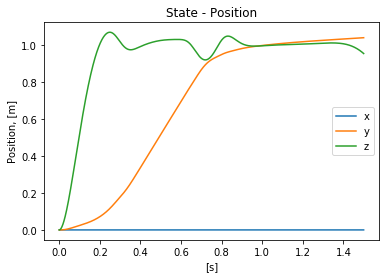

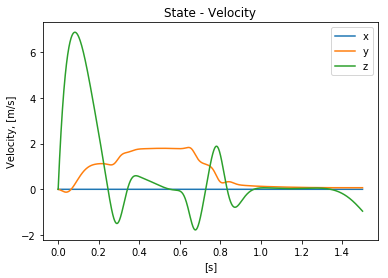

In [151]:
import matplotlib.pyplot as plt
t = np.arange(0., 1.5, dt)

plt.figure()
plt.plot(t, thrust)
plt.ylabel('Thrust, [N]')
plt.xlabel('[s]')
plt.title('Control - Thrust')

plt.figure()
plt.plot(t,Mr, t,Mp, t,My)
plt.legend(['Mr','Mp','My'])
plt.title('Control - Moments')
plt.ylabel('Moments, [Nm]')
plt.xlabel('[s]')

plt.figure()
t = np.append(t, 1.5)
plt.plot(t,Xx,t,Xy,t,Xz)
plt.legend(['x','y','z'])
plt.title('State - Position')
plt.ylabel('Position, [m]')
plt.xlabel('[s]')

plt.figure()
plt.plot(t,Vx,t,Vy,t,Vz)
plt.legend(['x','y','z'])
plt.title('State - Velocity')
plt.ylabel('Velocity, [m/s]')
plt.xlabel('[s]')